# Fog Detection Module

In [20]:
from commonfunctions import *
import math
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from skimage.transform  import (hough_line, hough_line_peaks)
from skimage.draw import line
from skimage.feature import blob_dog, blob_log, blob_doh
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Show the figures / plots inside the notebook
%matplotlib inline
from skimage.color import rgb2gray, rgba2rgb

def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

## Step(1)->sunny images exclusion

In [22]:
def sobel_fn(img,threshold):
    hx =  np.array([
        [-1,-2,-1],
        [ 0,0,0],
        [ 1,2,1]
    ])

    hy =  np.array([
        [ -1,0,1],
        [ -2,0,2],
        [ -1,0,1]
    ])
    xImg = convolve2d(img, hx)
    yImg= convolve2d(img, hy)
    
    newImg=np.sqrt(xImg**2+yImg**2) #edge strength
    
    newImg[newImg<threshold]=0
    newImg[newImg>threshold]=1
    
    return newImg

In [23]:
def SunnyImageDetection(img):
    #sobel edge detection
    # getting the height and width of the image to use them to define a threshold 
    width, height=img.shape
    # we use sobel edge detection to know if an image is sunny or not
    step1=sobel_fn(img,0.5)
    isSunny=np.sum(step1)
    result=False
    # we use a threshold as a factor of the images size
    if(isSunny >0.07*width*height):
        # if the image is found to be sunny it should be discarded and does not continue the rest of the processing
        result=True

        
    return result

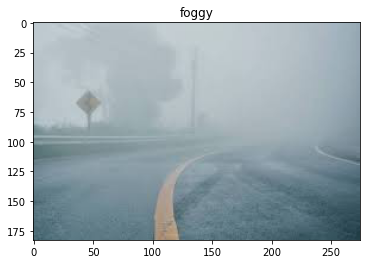

In [24]:
t=io.imread("Fog detection testcases/2.jpeg")
t1=rgb2gray(t)

# testing the image to see if it's sunny or not
res=SunnyImageDetection(t1)
if res:
    show_images([t],["sunny"])
else:
    show_images([t],["foggy"])

### After filtering out sunny images the next step is to find the degree of fogginess in the picture

## Step(2)->Hough Transform to get vanishing point

In [25]:
# our own implimentation of the hough transform
def houghTransform(img):
    step1=sobel_fn(img,0.3)
    width, height=img.shape
    
    # rMax is diagonal distance --> euclidean distance from origin point to end point
    rMax=round(math.dist((0,0),(height-1,width-1)))

    # Range of r is from -Rmax to Rmax
    # Range of theta from -90 to 90
    angles = np.arange(-90,90)
    cosineArray = np.cos(np.deg2rad(angles))
    sineArray = np.sin(np.deg2rad(angles))
    
    # create hough space where R is vertical axis and theta is horizontal
    rows = int(2* rMax)
    cols = len(angles)
    houghSpace = np.zeros((rows,cols))
    
    # Get indices of edge points
    yEdge , xEdge =  np.nonzero(step1)
    
    # Take steps to reduce computations
    for x,y in zip(xEdge, yEdge):
    #  we use a step size  of 2 or more to reduce computation time
        for theta in range(0,len(angles),1):
            # rMax is added to map r (from - Rmax to Rmax) value into hough space (from 0 to 2*Rma) 
            r = round(x*cosineArray[theta] + y*sineArray[theta])+ rMax -1
            if r >= houghSpace.shape[0]:
                continue
            houghSpace[r,theta]+=1
    
        
    return (step1, houghSpace)


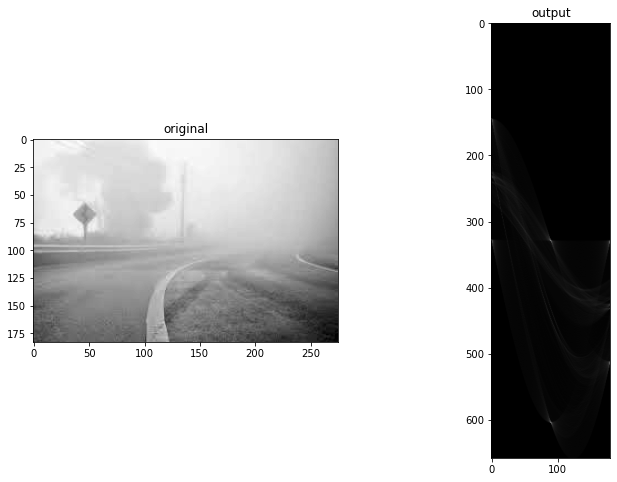

In [26]:
out, houghSpace = houghTransform(t1)
show_images([t1,houghSpace],["original", "output"])

In [27]:
# function to get the peak points in the hough space (ta2riban heya dih el 8alat)
def houghPeaks(houghSpace, threshold):
    r,a =  np.nonzero(houghSpace > threshold)
    return r,a

In [28]:
def VanishingPointDetection(t1):
    # getting the hough transform with built in function
    hough_space, angles, distances = hough_line(t1)
    thres = round(0.8* np.max(hough_space))
    # getting the angles and distances at peak points in the hough space
    acumm, a, r = hough_line_peaks(hough_space, angles, distances,thres)

    # drawing the dominating lines in the image and calculating the y value of the intersection (the vanishing point)
    lineImg = np.zeros(t1.shape) 
    fig, ax = plt.subplots()
    ax.imshow(t1)

    # transforming from polar coordinates to cartesian coordinates
    # V0 =alpha*U0 +beta
    aArr=np.zeros(len(r)) 
    bArr=np.zeros(len(r))
    alpha=np.zeros(len(r))
    beta=np.zeros(len(r))

    i = 0
    for  dist, angle in zip(r,a):
        # drawing the dominating lines
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])    
        ax.axline((x0, y0), slope=np.tan(angle + np.pi/2))
        # calculating aplha and beta to get cartisean coordinates
        aArr[i]=np.cos(angle)
        bArr[i]=np.sin(angle)
        alpha[i]= - (aArr[i]/bArr[i])
        beta[i]= (dist/bArr[i])
        i+=1
        
    # solving the 2 equations together   
    u0= np.ceil((beta[1]-beta[0])/(alpha[0]-alpha[1]))
    
    # getting the vanishing point->the point of intersection    
    yVanishing= alpha[0]*u0 + beta[0]
    # print("yVanishing = ",yVanishing)
        
    ax.set_xlim((0,lineImg.shape[1]))
    ax.set_ylim((lineImg.shape[0], 0))
    plt.tight_layout()
    plt.show()

    return yVanishing

## Step(3)-> Sky-Road segementation 

In [29]:
# el segmentation dih momken tetala3 2 regions


In [30]:
# our own implementation of the iterrative thresholding algorithm used to segment the sky from the road
def IterativeThresholding(img):
    
    img=(img).astype('uint8')
    
    numPixels= histogram(img)[0]
    greyLevels=histogram(img)[1]

    totalNumberOfPixels=np.cumsum(numPixels)[-1]
    numOfGreyPerK=0


    auxArray = numPixels * greyLevels
    numOfGreyPerK=np.cumsum(auxArray)[-1]
    Tinit=round(numOfGreyPerK/totalNumberOfPixels)
    a_num=numPixels[greyLevels<Tinit]
    a_glevels=greyLevels[greyLevels<Tinit]
    a_total=np.cumsum(a_num)[-1]

    b_num=numPixels[greyLevels>Tinit]
    b_glevels=greyLevels[greyLevels>Tinit]
    b_total=np.cumsum(b_num)[-1]

    auxArray_a= a_num * a_glevels
    auxArray_b= b_num * b_glevels

    T_a = round(np.cumsum(auxArray_a)[-1]/a_total)
    T_b = round(np.cumsum(auxArray_b)[-1]/b_total)
    T_new=(T_a+T_b)/2

    T_old=Tinit
    while(T_new !=T_old):
        a_num=numPixels[greyLevels<T_new]
        a_glevels=greyLevels[greyLevels<T_new]
        a_total=np.cumsum(a_num)[-1]

        b_num=numPixels[greyLevels>T_new]
        b_glevels=greyLevels[greyLevels>T_new]
        b_total=np.cumsum(b_num)[-1]

        auxArray_a= a_num * a_glevels
        auxArray_b= b_num * b_glevels

        T_a = round(np.cumsum(auxArray_a)[-1]/a_total)
        T_b = round(np.cumsum(auxArray_b)[-1]/b_total)

        T_old=T_new
        T_new=(T_a+T_b)/2
        
    img[img>T_new]=255
    img[img<T_new]=0
    return img

## Step(4)-> Getting regions endline

#### In this section we an approximated line for the limit between the road and the sky ,We then compare the Y coordinate of this line with the Y coordinate of the vanishing point calculated in the last section
#### the precentage of difference between these 2 points gets us the degree of fogginess in the image 

In [31]:
def SkyRoadLimitHeight(t1,out1):
    # for approximation purposes we will get the y coordinate of the intersection between the sky and the road segment at
    # 3 different places
    h,w= t1.shape

    # the 3 values of the x coordinate at which we will calculate
    q_1= w//4
    q_2= w//2
    q_3= (3*w)//4

    # the values of the y coordinates that will be averaged together
    r_1= 0
    r_2= 0
    r_3= 0

    # getting the values of the y coordinates to be averaged with 3 for loops
    for i in range(0,h,1):
        if out1[i][q_1] <  1:
            r_1= i
            break

    for i in range(0,h,1):
        if out1[i][q_2] <  1:
            r_2= i
            break        

    for i in range(0,h,1):
        if out1[i][q_3] <  1:
            r_3= i
            break
            
    # the Y coordinate that represents the line of intersection between the sky and the road
    yAvg = (r_1 + r_2 + r_3)//3
    # print("yAvg= ",yAvg)

    # drawing this line of intersection
    x = [0, w-1]
    y = [yAvg,yAvg] # the y we got after averaging 3 values of the top of the image to the first different pixel
    plt.plot(x, y, color="red", linewidth=3)
    plt.imshow(t1)
    plt.show()

    return yAvg



## Final Step-> calculating the degree of fogginess in the picture

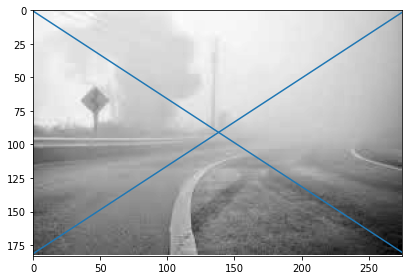

yVanish =  90.39123199890207


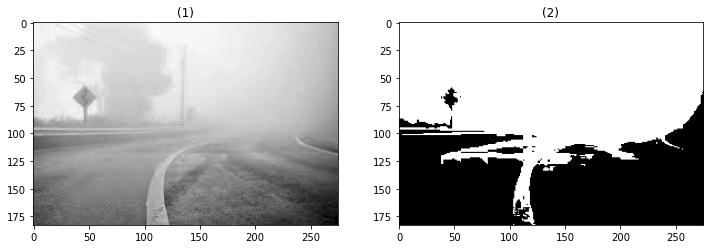

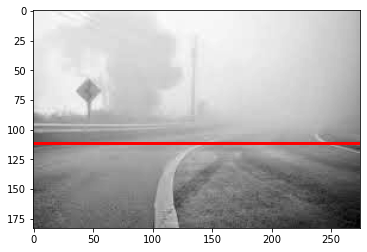

yAvg=  111
fogginess=  22.8 %


In [32]:
yVanishing = VanishingPointDetection(t1)
print("yVanish = ",yVanishing)
out1=IterativeThresholding(t1*255)
show_images([t1,out1])
yAvg =SkyRoadLimitHeight(t1,out1)
print("yAvg= ",yAvg)
fogginess = abs(yVanishing - yAvg)/ yVanishing
print("fogginess= ",round(fogginess*100,3),"%")